# Pyroomacoustics Demo

### dependencies:  pyroomacoustics, pysoundfile, samplerate

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra
import soundfile

plt.rcParams['font.size'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

%matplotlib inline

import librosa
import librosa.display
import samplerate

import IPython.display as ipd

from scipy import signal

import pyroomacoustics as pra
from pyroomacoustics.doa import circ_dist

import pandas as pd

%load_ext autoreload
%autoreload 2
from doa_lib import *

## Read file and show it in spectogram 

In [10]:
fs

44100

In [11]:
data.shape

(88200,)

In [18]:
np.sin((1./fs)*np.arange(data.shape[0]))


array([0.00000000e+00, 2.26757370e-05, 4.53514739e-05, ...,
       9.09325734e-01, 9.09316299e-01, 9.09306863e-01])

-11.481842 68.51816


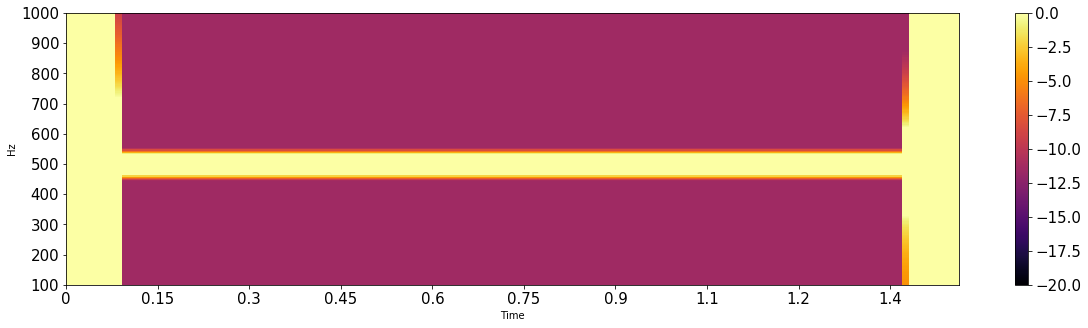

In [35]:
clim = (-20, 0)
spect(np.sin(2*np.pi*500*(1./fs)*np.arange(data.shape[0])),fs, figsize=[20,5])
plt.colorbar()
plt.clim(clim)

In [42]:
rec_signal.shape

(2, 89092)

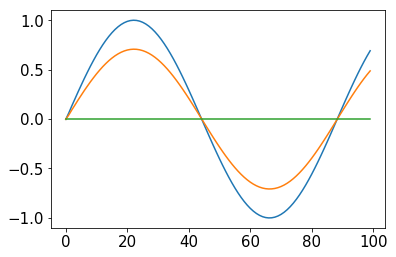

In [48]:
plt.plot(rec_signal[0,40:140])
plt.plot(rec_signal[1,40:140])
plt.plot(0*rec_signal[1,40:140])
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


-57.926224 22.073776
-57.92409 22.075909
-57.924103 22.075897


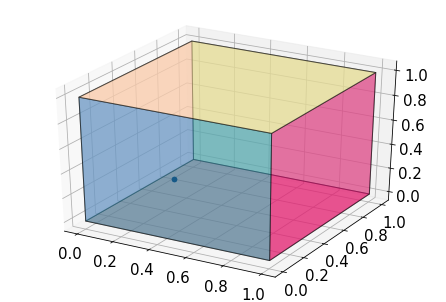

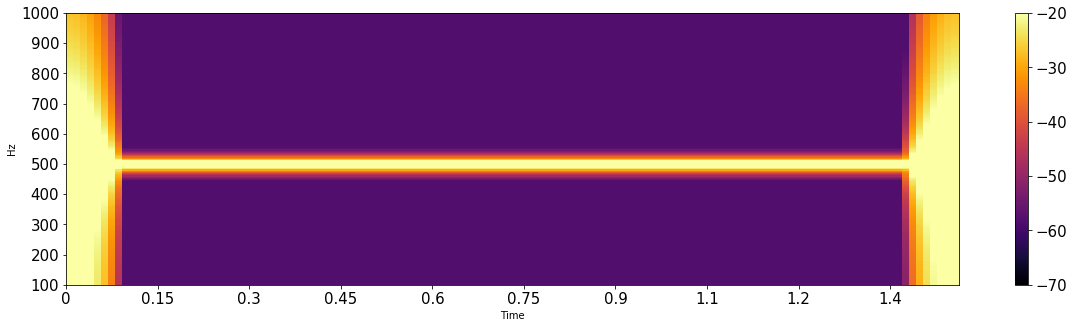

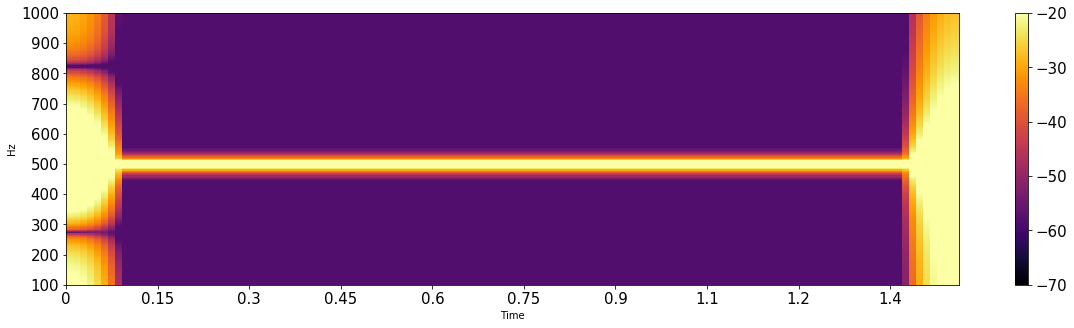

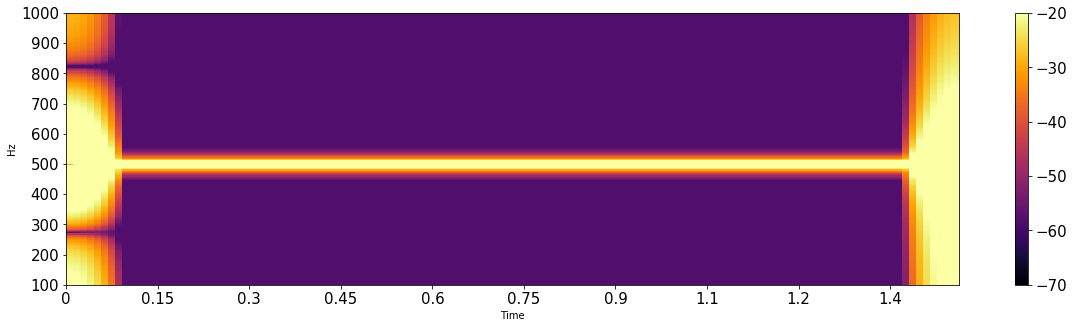

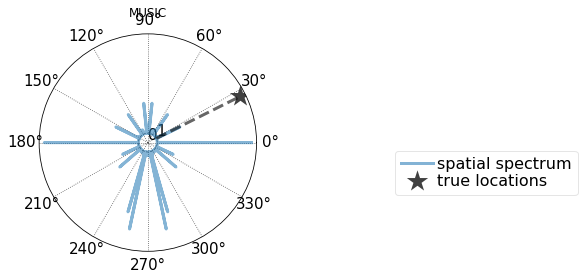

In [39]:
file_name = '../recordings/180910_142834.wav'
algo_name = 'MUSIC'
room_dim = [10000, 10000, 10000]
r_source=np.c_[[5005, 5, 5000]]
r_rec=np.c_[
    [5000, 5, 5000],  # mic 1
    [5000, 10, 5000],  # mic 2
    ]

rx_center = r_rec.mean(axis=1, keepdims=True)
v = r_source-rx_center
base_vec = np.c_[[1,0,0]]
c = np.dot(v.T, base_vec)/np.linalg.norm(base_vec)/np.linalg.norm(v) # -> cosine of the angle
angle = np.arccos(np.clip(c, -1, 1)) # if you really want the angle
azimuth = [angle[0,0]]

# reshape into 1d numpy array
r_source = r_source[:,0]

fs = 44100
data, fs = read_sound(file_name, time=[285, 287])
data = np.sin(2*np.pi*500*(1./fs)*np.arange(data.shape[0]))

rec_signal = sim_room(data, fs, absorption=0.1, r_source=r_source, r_rec=r_rec, room_dim=room_dim)

rec_signal_noised = add_noise(rec_signal, SNR=100, noise_id=(0,1), noise_location_doc='silence_180910_142834.txt')
clim = (-70,-20)

if 1:
    spect(data/np.sqrt(np.sum(data**2)), fs, figsize=[20,5])
    plt.colorbar()
    plt.clim(clim)

    spect(rec_signal_noised[0,:], fs, figsize=[20,5])
    plt.colorbar()
    plt.clim(clim)

    spect(rec_signal_noised[1,:], fs, figsize=[20,5])
    plt.colorbar()
    plt.clim(clim)

nfft = 1024*8
overlap_ratio = 1
X = np.array([produce_spect_for_music(channel_sig, nfft=nfft, overlap_ratio=overlap_ratio, fft_type='rfft')
              for channel_sig in rec_signal_noised])

doa = locate_source(X[:, :, 5:7], r_rec, fs, nfft, algo_name, freq_range = [300., 800.])
plot_doa(doa, azimuth, algo_name)
